<VSCode.Cell language="markdown">
# EDA: Microbiology Dataset & Model Analysis
This notebook explores the dataset `microbiology_combined_clean.csv` and evaluates models with a focus on antibiotic resistance prediction.
</VSCode.Cell>
<VSCode.Cell language="python">
# Setup and Imports
import os
import json
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try seaborn for nicer plots if available
try:
    import seaborn as sns
    sns.set(style="whitegrid")
except ImportError:
    sns = None

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import joblib

# Global seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
plt.rcParams["figure.figsize"] = (10, 6)
</VSCode.Cell>
<VSCode.Cell language="python">
# Load Dataset
DATASET_PATH = "microbiology_combined_clean.csv"
df = pd.read_csv(DATASET_PATH)
print("Shape:", df.shape)
df.head()
</VSCode.Cell>
<VSCode.Cell language="python">
# Quick Data Summary
print("Dtypes:\n", df.dtypes)
print("\nMissing values (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))

print("\nUnique values per column (top 20):")
unique_counts = df.nunique(dropna=False).sort_values(ascending=False).head(20)
print(unique_counts)

# Memory usage
mem_usage_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"\nApprox. memory usage: {mem_usage_mb:.2f} MB")
</VSCode.Cell>
<VSCode.Cell language="python">
# Data Cleaning and Type Inference

# Drop duplicate rows if any
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Dropped duplicates: {before - after}")

# Parse date-like columns if present
for col in df.columns:
    if "time" in col.lower() and df[col].dtype == object:
        try:
            df[col] = pd.to_datetime(df[col], errors="coerce")
        except Exception:
            pass

# Numeric conversions for obvious numeric fields stored as object
likely_numeric = [
    "was_positive",
    "time_to_culturetime",
    "medication_time_to_culturetime",
    "prior_infecting_organism_days_to_culutre",
]
for col in likely_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Simple outlier detection via z-score for numeric columns
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
z_scores = {}
for c in num_cols:
    series = df[c].dropna()
    if series.std() > 0:
        z = (series - series.mean()) / series.std()
        z_scores[c] = (np.abs(z) > 4).sum()  # count extreme outliers
print("\nOutlier counts (|z|>4) for numeric columns:")
print({k: v for k, v in z_scores.items() if v > 0})
</VSCode.Cell>
<VSCode.Cell language="python">
# EDA: Univariate Distributions

# Numeric histograms
for c in num_cols[:10]:  # limit to first 10 for brevity
    plt.figure()
    df[c].hist(bins=30)
    plt.title(f"Histogram: {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()

# Categorical top frequency plots
cat_cols = [c for c in df.columns if df[c].dtype == object]
for c in cat_cols[:5]:  # limit for brevity
    plt.figure()
    vc = df[c].value_counts(dropna=False).head(20)
    if sns:
        sns.barplot(x=vc.values, y=vc.index)
    else:
        plt.barh(vc.index.astype(str), vc.values)
    plt.title(f"Top categories: {c}")
    plt.xlabel("Count")
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()
</VSCode.Cell>
<VSCode.Cell language="python">
# EDA: Bivariate and Correlations

if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(12, 10))
    if sns:
        sns.heatmap(corr, cmap="coolwarm", center=0)
    else:
        plt.imshow(corr, cmap="coolwarm")
        plt.colorbar()
        plt.xticks(range(len(num_cols)), num_cols, rotation=90)
        plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()

# Pairplot sample if seaborn is available
if sns and len(num_cols) >= 2:
    sns.pairplot(df[num_cols[:5]].dropna().sample(min(500, len(df))), diag_kind="hist")
</VSCode.Cell>
<VSCode.Cell language="python">
# Target Analysis and Problem-Type Detection

susceptibility_col = None
for c in df.columns:
    if c.lower() == "susceptibility":
        susceptibility_col = c
        break

if susceptibility_col:
    print("Target column:", susceptibility_col)
    print(df[susceptibility_col].value_counts(dropna=False))
    # Binary RS mapping: Resistant=1, Susceptible/Intermediate=0
    y_rs = df[susceptibility_col].astype(str).map({"Resistant":1, "Susceptible":0, "Intermediate":0})
    print("\nBinary RS class balance:")
    print(y_rs.value_counts(dropna=False))
else:
    print("No susceptibility column detected.")
</VSCode.Cell>
<VSCode.Cell language="python">
# Train/Validation Split (Classification if target detected)

if susceptibility_col:
    # Simple feature set: use non-leakage columns
    X = df.drop(columns=[susceptibility_col])
    y = df[susceptibility_col].astype(str).map({"Resistant":1, "Susceptible":0, "Intermediate":0})
    mask = ~y.isna()
    X, y = X.loc[mask], y.loc[mask].astype(int)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )
    print("Train/Val sizes:", X_train.shape, X_val.shape)
else:
    X_train = X_val = y_train = y_val = None
    print("Skipping split: target not available.")
</VSCode.Cell>
<VSCode.Cell language="python">
# Preprocessing Pipeline

if X_train is not None:
    num_features = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
    cat_features = [c for c in X_train.columns if c not in num_features]

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_features),
            ("cat", categorical_transformer, cat_features),
        ]
    )
else:
    preprocessor = None
</VSCode.Cell>
<VSCode.Cell language="python">
# Baseline Model

if preprocessor is not None:
    baseline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", DummyClassifier(strategy="most_frequent")),
    ])
    baseline.fit(X_train, y_train)
    y_pred = baseline.predict(X_val)
    print({
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
    })
</VSCode.Cell>
<VSCode.Cell language="python">
# Model Training with Cross-Validation (RandomForest)

if preprocessor is not None:
    rf = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(n_estimators=200, max_depth=None, random_state=SEED)),
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    auc_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring="roc_auc")
    print("CV ROC-AUC:", auc_scores, "mean=", auc_scores.mean())
    rf.fit(X_train, y_train)
</VSCode.Cell>
<VSCode.Cell language="markdown">
## Model Evaluation Metrics
- Classification: accuracy, precision, recall, F1.
- ROC-AUC and ROC curve.

$F1=2\cdot\frac{precision\cdot recall}{precision+recall}$
</VSCode.Cell>
<VSCode.Cell language="python">
# Evaluate on validation set

if preprocessor is not None:
    y_prob = rf.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    print({
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "roc_auc": roc_auc_score(y_val, y_prob),
    })

    fpr, tpr, thr = roc_curve(y_val, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc_score(y_val, y_prob):.3f}")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Validation)")
    plt.legend()
    plt.show()
</VSCode.Cell>
<VSCode.Cell language="python">
# Hyperparameter Tuning (GridSearchCV)

from sklearn.model_selection import GridSearchCV

if preprocessor is not None:
    rf_base = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(random_state=SEED)),
    ])
    grid = {
        "model__n_estimators": [100, 200],
        "model__max_depth": [None, 10, 20],
    }
    gs = GridSearchCV(rf_base, grid, cv=3, scoring="roc_auc", n_jobs=-1)
    gs.fit(X_train, y_train)
    print("Best params:", gs.best_params_)
    print("Best score:", gs.best_score_)
</VSCode.Cell>
<VSCode.Cell language="python">
# Feature Importance and Permutation Importance

if preprocessor is not None:
    rf_best = gs.best_estimator_ if 'gs' in globals() else rf
    # Model-based importance for RandomForest
    model = rf_best.named_steps["model"]
    if hasattr(model, "feature_importances_"):
        ohe = rf_best.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
        num_features = rf_best.named_steps["preprocess"].transformers_[0][2]
        cat_features = rf_best.named_steps["preprocess"].transformers_[1][2]
        cat_ohe_names = list(ohe.get_feature_names_out(cat_features))
        feature_names = list(num_features) + cat_ohe_names
        importances = model.feature_importances_
        # Show top 20
        idx = np.argsort(importances)[::-1][:20]
        plt.figure(figsize=(10, 8))
        labels = [feature_names[i] for i in idx]
        vals = importances[idx]
        if sns:
            sns.barplot(x=vals, y=labels)
        else:
            plt.barh(labels, vals)
            plt.gca().invert_yaxis()
        plt.title("Top Feature Importances (RandomForest)")
        plt.tight_layout()
        plt.show()

    # Permutation importance
    pi = permutation_importance(rf_best, X_val, y_val, n_repeats=5, random_state=SEED, scoring="roc_auc")
    perm_idx = np.argsort(pi.importances_mean)[::-1][:20]
    plt.figure(figsize=(10, 8))
    plt.barh(np.array(feature_names)[perm_idx], pi.importances_mean[perm_idx])
    plt.gca().invert_yaxis()
    plt.title("Top Permutation Importances")
    plt.tight_layout()
    plt.show()
</VSCode.Cell>
<VSCode.Cell language="python">
# Save Artifacts (Model, Preprocessor, Metrics)

OUT_DIR = "models"
os.makedirs(OUT_DIR, exist_ok=True)
if preprocessor is not None:
    joblib.dump(rf, os.path.join(OUT_DIR, "sklearn_rf_pipeline.joblib"))
    metrics = {
        "val": {
            "roc_auc": float(roc_auc_score(y_val, rf.predict_proba(X_val)[:,1])),
        }
    }
    with open(os.path.join(OUT_DIR, "sklearn_metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
</VSCode.Cell>
<VSCode.Cell language="python">
# Inference on New Samples

def predict_row(pipeline: Pipeline, row: dict) -> dict:
    X_row = pd.DataFrame([row])
    proba = pipeline.predict_proba(X_row)[:, 1][0]
    pred = int(proba >= 0.5)
    return {"proba": float(proba), "pred": pred}

if preprocessor is not None:
    sample = X_val.iloc[0].to_dict()
    print(predict_row(rf, sample))
</VSCode.Cell>
<VSCode.Cell language="python">
# Unit Tests (basic checks)

if preprocessor is not None:
    # After transform, no NaNs
    Xt = preprocessor.fit_transform(X_train)
    if hasattr(Xt, "toarray"):
        Xt = Xt.toarray()
    assert not np.isnan(Xt).any(), "Transformed features contain NaNs!"
    print("Preprocessing test passed: No NaNs after transform.")
</VSCode.Cell>
<VSCode.Cell language="python">
# Read Trained CatBoost Model Metadata and Metrics
meta_path = os.path.join("models", "metadata.json")
metrics_path = os.path.join("models", "metrics.json")
if os.path.exists(meta_path):
    meta = json.load(open(meta_path, "r"))
    print("\nCatBoost Metadata keys:", list(meta.keys()))
    print("Classifier best threshold:", meta.get("best_threshold"))
if os.path.exists(metrics_path):
    print("\nCatBoost Metrics:")
    print(json.load(open(metrics_path, "r")))
</VSCode.Cell>
<VSCode.Cell language="python">
# CatBoost Feature Importance (if model is available)
try:
    from catboost import CatBoostClassifier
    meta = json.load(open(os.path.join("models", "metadata.json"), "r"))
    cls_path = meta.get("classifier_model_path")
    feature_cols = meta.get("feature_cols", [])
    if cls_path and os.path.exists(cls_path):
        model = CatBoostClassifier()
        model.load_model(cls_path)
        X_cb = df[feature_cols]
        importances = model.get_feature_importance(X_cb)
        idx = np.argsort(importances)[::-1][:20]
        plt.figure(figsize=(10,8))
        labels = [feature_cols[i] for i in idx]
        vals = importances[idx]
        if sns:
            sns.barplot(x=vals, y=labels)
        else:
            plt.barh(labels, vals)
            plt.gca().invert_yaxis()
        plt.title("Top Feature Importances (CatBoost)")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("CatBoost importance failed:", e)
</VSCode.Cell>

In [1]:
# Setup and Imports
import os
import json
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try seaborn for nicer plots if available
try:
    import seaborn as sns
    sns.set(style="whitegrid")
except ImportError:
    sns = None

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import joblib

# Global seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# Load Dataset
DATASET_PATH = "microbiology_combined_clean.csv"
df = pd.read_csv(DATASET_PATH)
print("Shape:", df.shape)
df.head()

Shape: (41561, 21)


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,medication_category,medication_name,antibiotic_class,time_to_culturetime,ordering_mode,culture_description,...,organism,antibiotic,susceptibility,age,gender,implied_susceptibility,resistant_time_to_culturetime,medication_time_to_culturetime,prior_organism,prior_infecting_organism_days_to_culutre
0,JC1000129,131348917413,855365600,2023-01-20 09:30:00+00:00,ZIT,Zithromax,Macrolide Lincosamide,1934,Inpatient,URINE,...,ESCHERICHIA COLI,Trimethoprim/Sulfamethoxazole,Resistant,85-89 years,1,Null,24,13,Escherichia,21
1,JC1000129,131354606122,876959985,2023-04-23 22:44:00+00:00,SUL,Sulfamethoxazole-Trimethoprim,Combination Antibiotic,814,Inpatient,BLOOD,...,PROTEUS MIRABILIS,Meropenem,Susceptible,85-89 years,1,Resistant,117,0,Escherichia,91
2,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,ZIT,Zithromax,Macrolide Lincosamide,2102,Inpatient,URINE,...,PROTEUS MIRABILIS,Nitrofurantoin,Resistant,85-89 years,1,Resistant,80,36,Escherichia,76
3,JC1000169,131020175980,405642359,2012-07-25 23:25:00+00:00,CLI1,Clindamycin Phosphate,Macrolide Lincosamide,418,Inpatient,URINE,...,ENTEROBACTER CLOACAE,Ciprofloxacin,Susceptible,45-54 years,0,Null,1140,418,Enterobacter,1138
4,JC1000169,131186502229,494269657,2016-04-27 23:50:00+00:00,PEN,Penicillin,Beta Lactam,2060,Outpatient,URINE,...,ESCHERICHIA COLI,Ampicillin,Resistant,45-54 years,0,Null,2512,0,Enterobacter,2510


In [3]:
# Quick Data Summary
print("Dtypes:\n", df.dtypes)
print("\nMissing values (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))

print("\nUnique values per column (top 20):")
unique_counts = df.nunique(dropna=False).sort_values(ascending=False).head(20)
print(unique_counts)

# Memory usage
mem_usage_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"\nApprox. memory usage: {mem_usage_mb:.2f} MB")

Dtypes:
 anon_id                                     object
pat_enc_csn_id_coded                         int64
order_proc_id_coded                          int64
order_time_jittered_utc                     object
medication_category                         object
medication_name                             object
antibiotic_class                            object
time_to_culturetime                          int64
ordering_mode                               object
culture_description                         object
was_positive                                 int64
organism                                    object
antibiotic                                  object
susceptibility                              object
age                                         object
gender                                       int64
implied_susceptibility                      object
resistant_time_to_culturetime                int64
medication_time_to_culturetime               int64
prior_organism        

In [4]:
# Data Cleaning and Type Inference

# Drop duplicate rows if any
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Dropped duplicates: {before - after}")

# Parse date-like columns if present
for col in df.columns:
    if "time" in col.lower() and df[col].dtype == object:
        try:
            df[col] = pd.to_datetime(df[col], errors="coerce")
        except Exception:
            pass

# Numeric conversions for obvious numeric fields stored as object
likely_numeric = [
    "was_positive",
    "time_to_culturetime",
    "medication_time_to_culturetime",
    "prior_infecting_organism_days_to_culutre",
]
for col in likely_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Simple outlier detection via z-score for numeric columns
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
z_scores = {}
for c in num_cols:
    series = df[c].dropna()
    if series.std() > 0:
        z = (series - series.mean()) / series.std()
        z_scores[c] = (np.abs(z) > 4).sum()  # count extreme outliers
print("\nOutlier counts (|z|>4) for numeric columns:")
print({k: v for k, v in z_scores.items() if v > 0})

Dropped duplicates: 0

Outlier counts (|z|>4) for numeric columns:
{'pat_enc_csn_id_coded': 485, 'time_to_culturetime': 138, 'resistant_time_to_culturetime': 246, 'medication_time_to_culturetime': 567, 'prior_infecting_organism_days_to_culutre': 226}


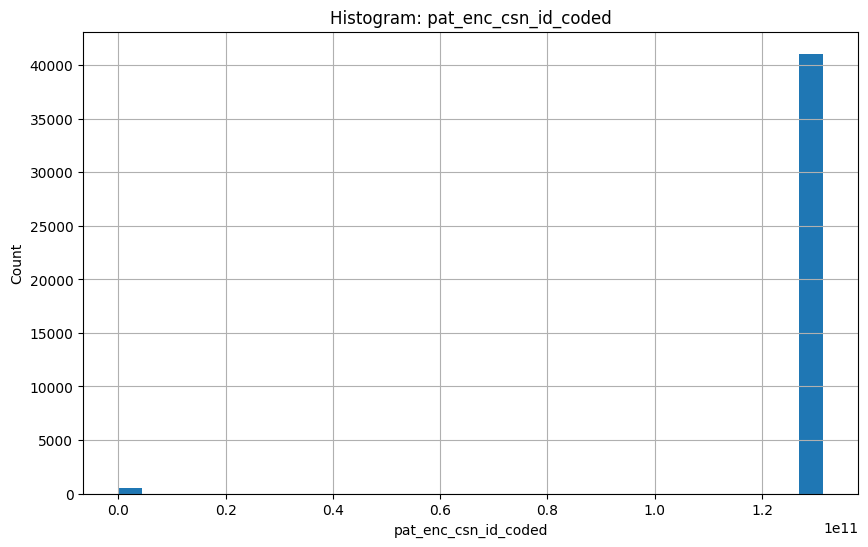

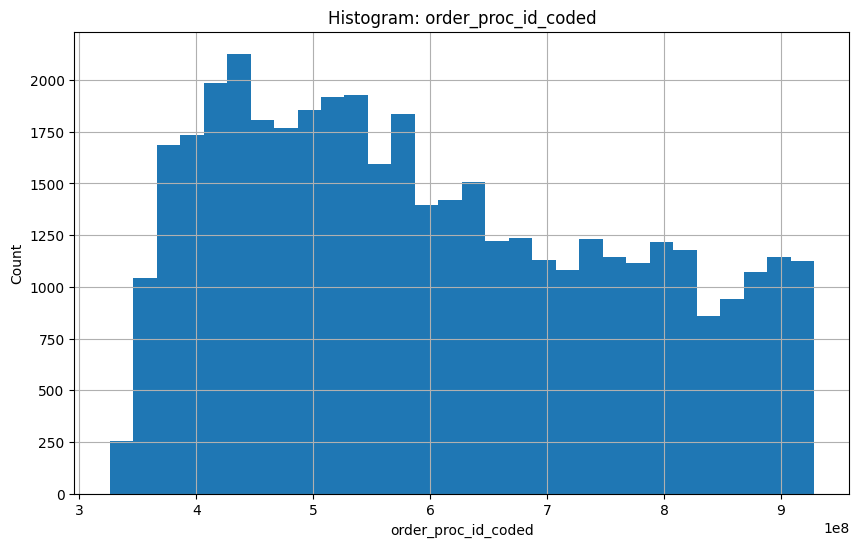

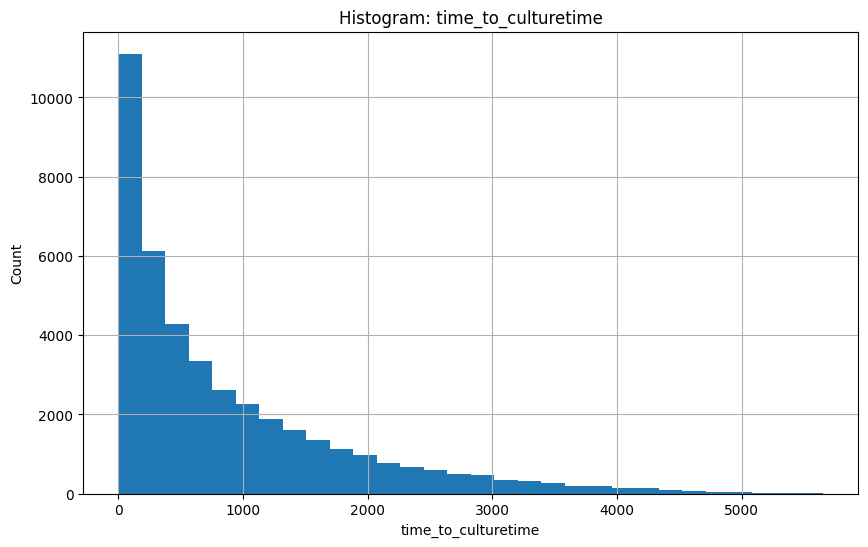

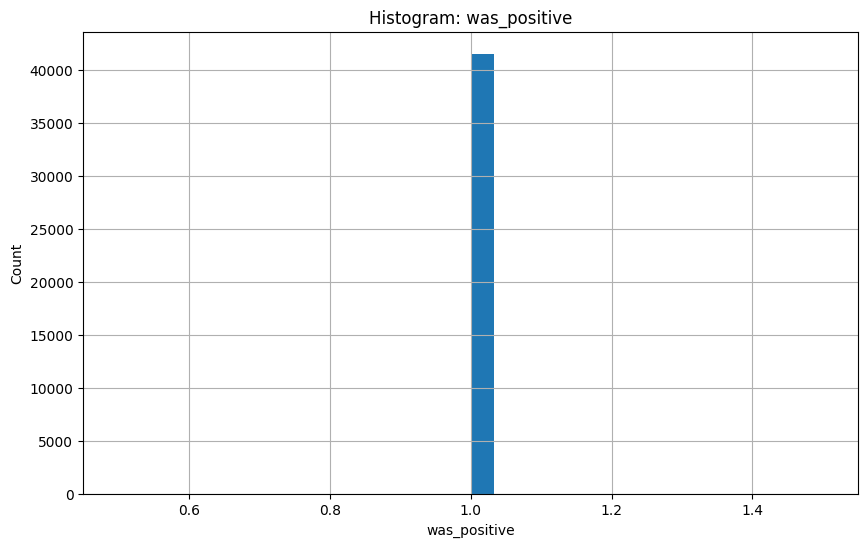

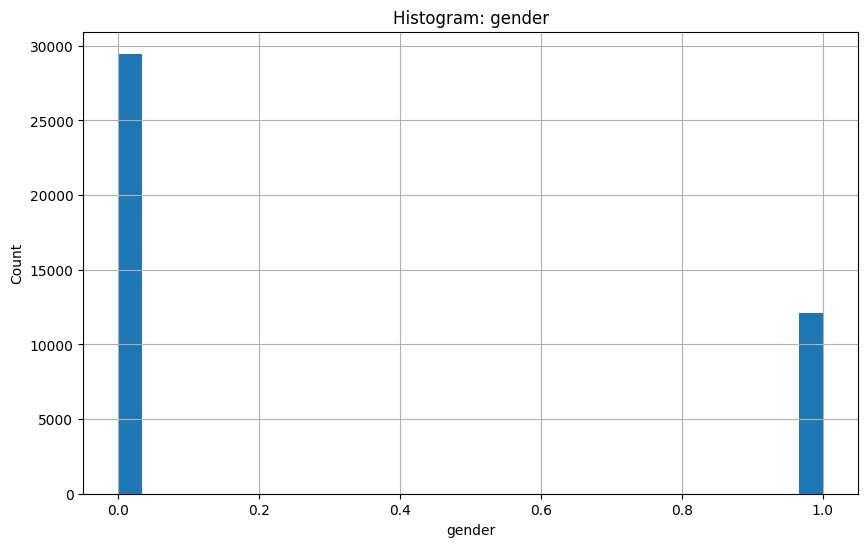

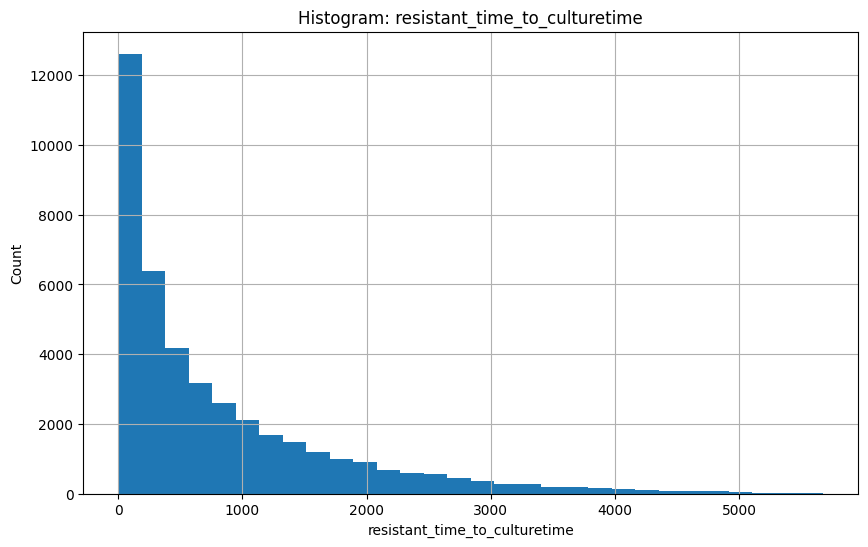

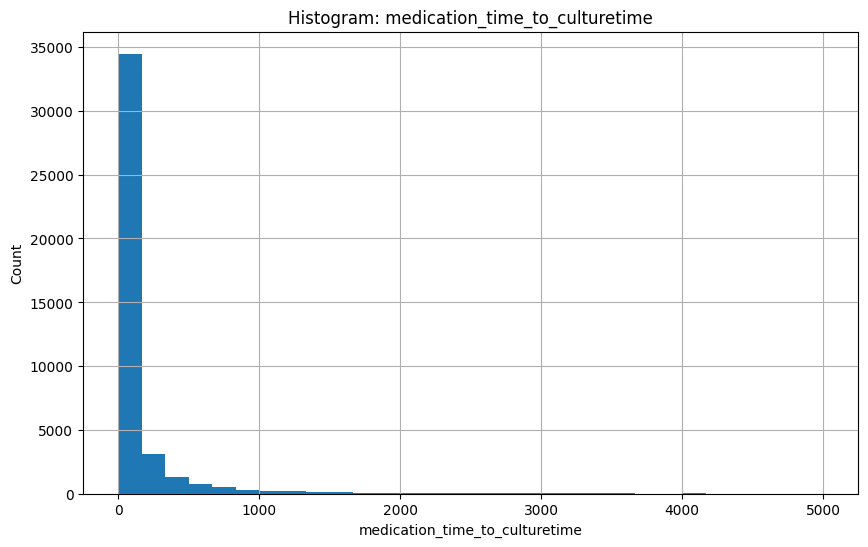

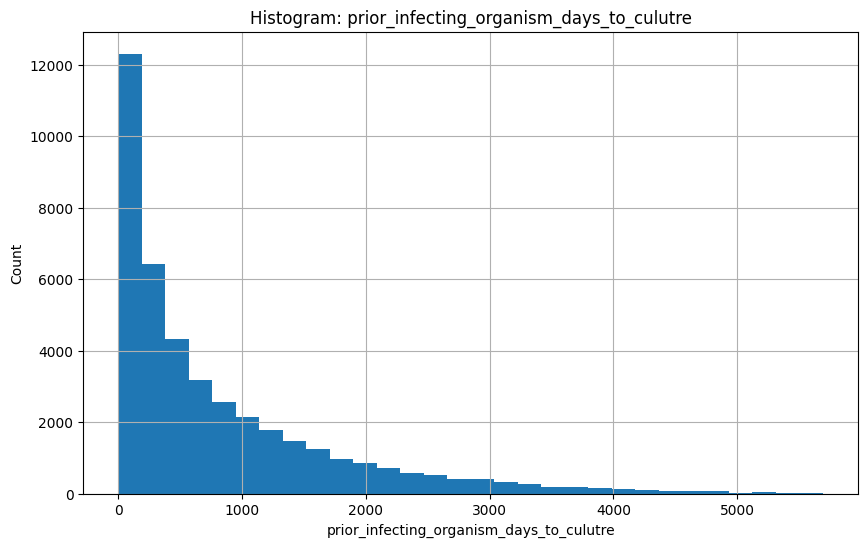

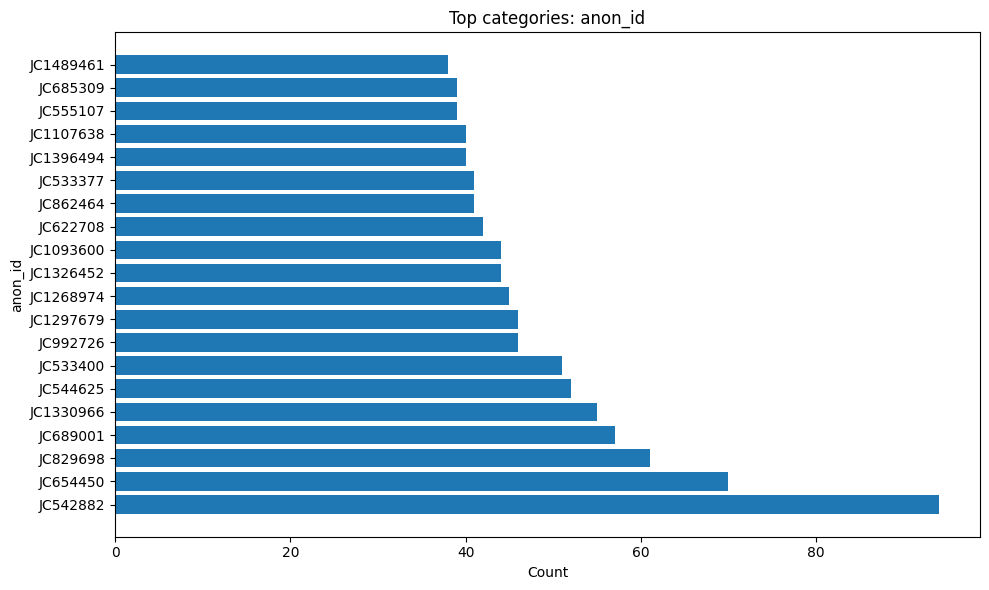

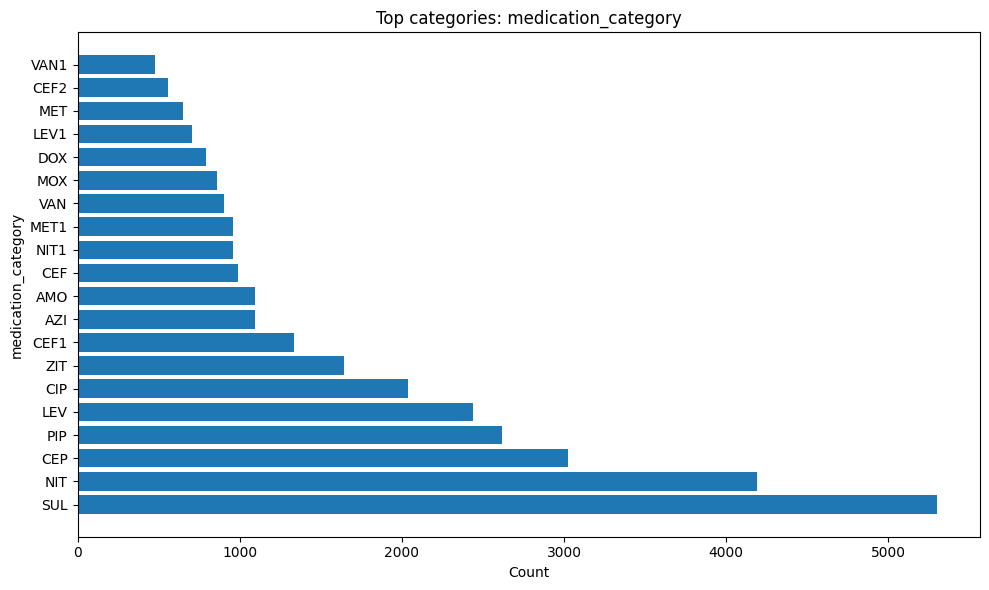

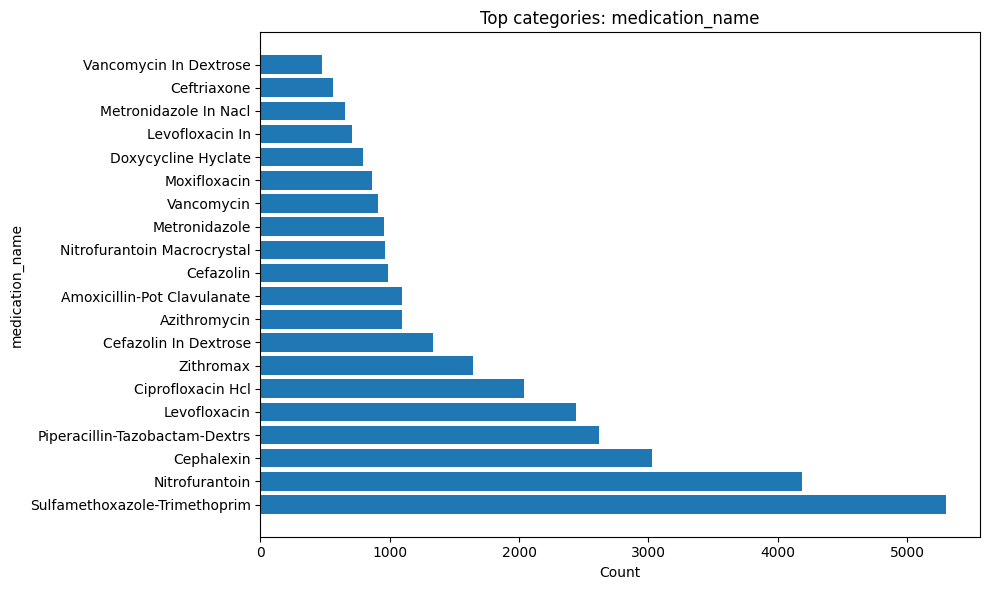

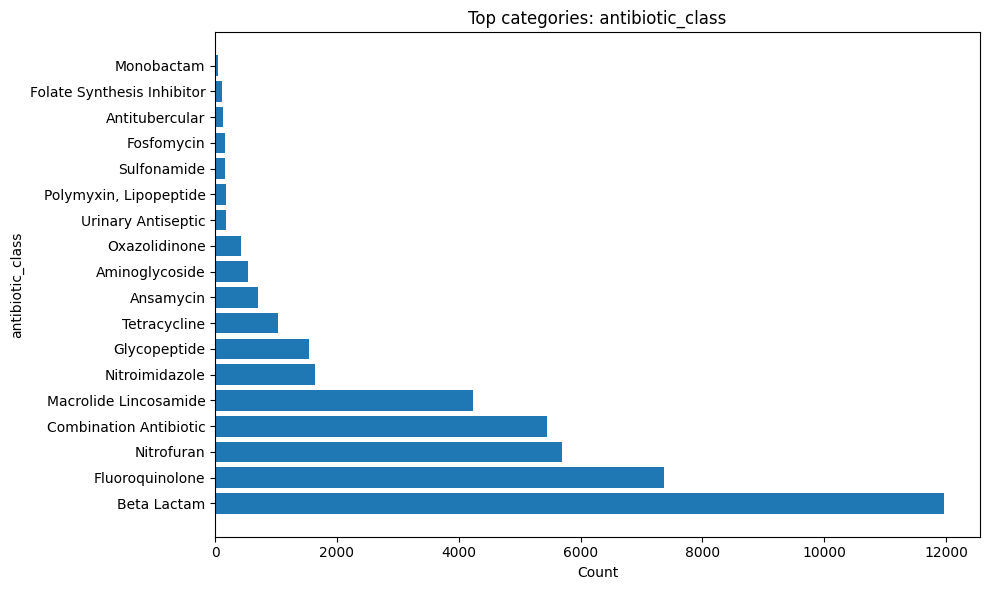

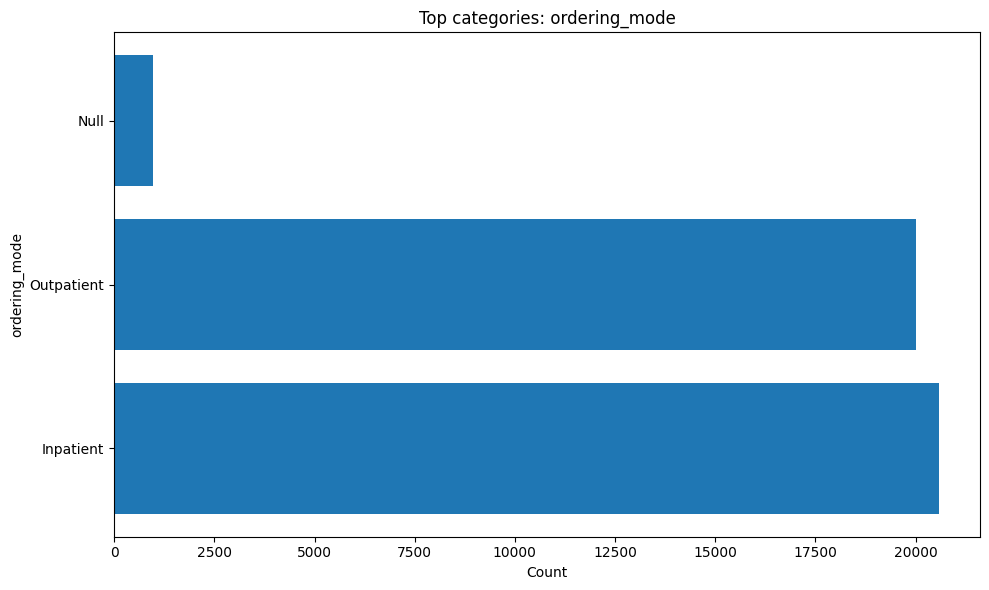

In [5]:
# EDA: Univariate Distributions

# Numeric histograms
for c in num_cols[:10]:  # limit to first 10 for brevity
    plt.figure()
    df[c].hist(bins=30)
    plt.title(f"Histogram: {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()

# Categorical top frequency plots
cat_cols = [c for c in df.columns if df[c].dtype == object]
for c in cat_cols[:5]:  # limit for brevity
    plt.figure()
    vc = df[c].value_counts(dropna=False).head(20)
    if sns:
        sns.barplot(x=vc.values, y=vc.index)
    else:
        plt.barh(vc.index.astype(str), vc.values)
    plt.title(f"Top categories: {c}")
    plt.xlabel("Count")
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()

In [8]:
# Ensure target detection variables exist for downstream cells
SEED = 42
susceptibility_col = 'susceptibility' if 'susceptibility' in df.columns else None
ttr_col = 'resistant_time_to_culturetime' if 'resistant_time_to_culturetime' in df.columns else None
print('Detected target columns:', susceptibility_col, ttr_col)

Detected target columns: susceptibility resistant_time_to_culturetime


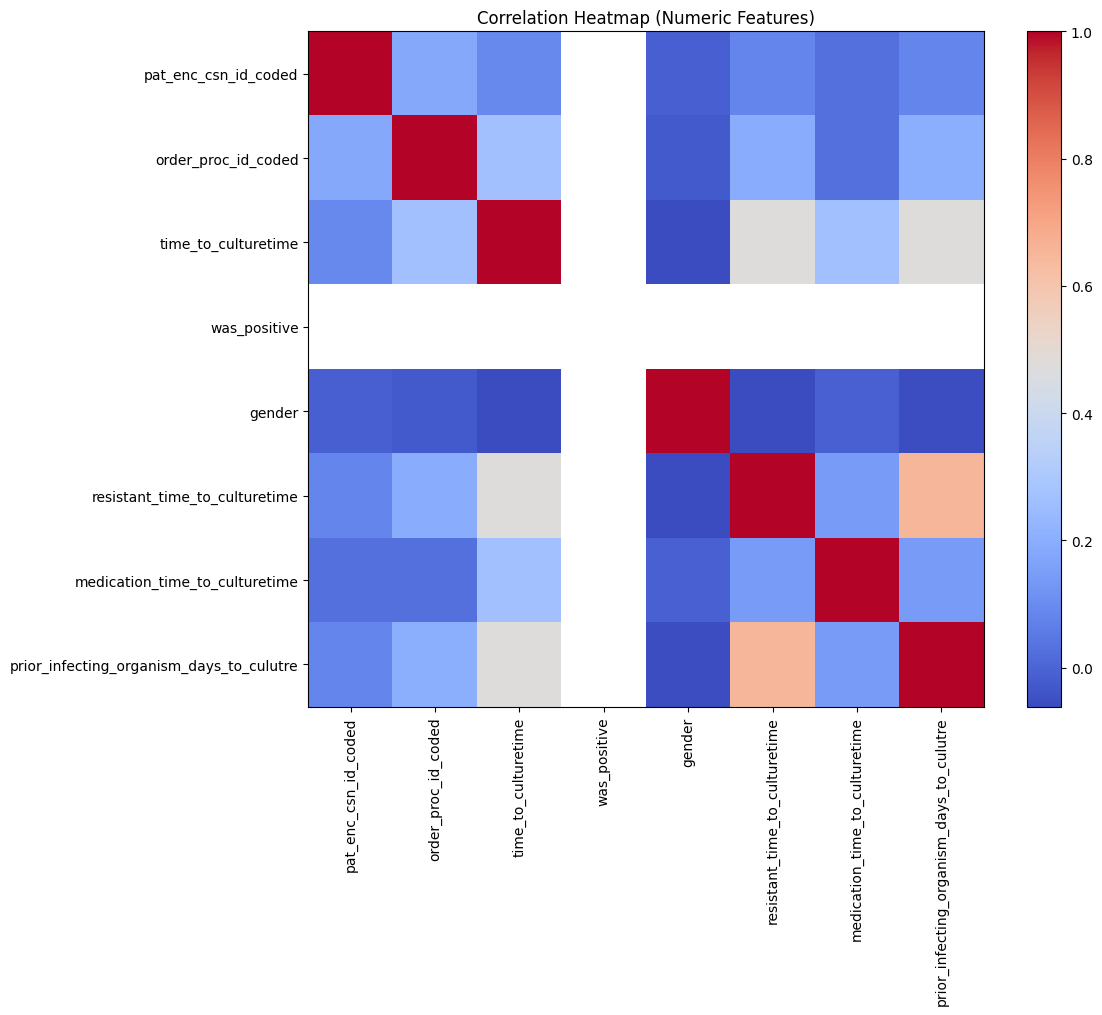

In [6]:
# EDA: Bivariate and Correlations

if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(12, 10))
    if sns:
        sns.heatmap(corr, cmap="coolwarm", center=0)
    else:
        plt.imshow(corr, cmap="coolwarm")
        plt.colorbar()
        plt.xticks(range(len(num_cols)), num_cols, rotation=90)
        plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()

# Pairplot sample if seaborn is available
if sns and len(num_cols) >= 2:
    sns.pairplot(df[num_cols[:5]].dropna().sample(min(500, len(df))), diag_kind="hist")

In [ ]:
# Target Analysis and Problem-Type Detection

susceptibility_col = None
for c in df.columns:
    if c.lower() == "susceptibility":
        susceptibility_col = c
        break

if susceptibility_col:
    print("Target column:", susceptibility_col)
    print(df[susceptibility_col].value_counts(dropna=False))
    # Binary RS mapping: Resistant=1, Susceptible/Intermediate=0
    y_rs = df[susceptibility_col].astype(str).map({"Resistant":1, "Susceptible":0, "Intermediate":0})
    print("\nBinary RS class balance:")
    print(y_rs.value_counts(dropna=False))
else:
    print("No susceptibility column detected.")

In [9]:
# Train/Validation Split (Classification if target detected)

if susceptibility_col:
    # Simple feature set: use non-leakage columns
    X = df.drop(columns=[susceptibility_col])
    y = df[susceptibility_col].astype(str).map({"Resistant":1, "Susceptible":0, "Intermediate":0})
    mask = ~y.isna()
    X, y = X.loc[mask], y.loc[mask].astype(int)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )
    print("Train/Val sizes:", X_train.shape, X_val.shape)
else:
    X_train = X_val = y_train = y_val = None
    print("Skipping split: target not available.")

Train/Val sizes: (33040, 20) (8261, 20)


In [11]:
# Inference test: use first row as deterministic case
from backend.infer import ModelBundle, predict_for_new_patient
from backend.recommend import rank_antibiotics
import math

bundle = ModelBundle(models_dir='models')
bundle.load()

feature_cols = bundle.feature_columns()
cat_cols = bundle.metadata.get('categorical_feature_cols', [])
row0 = df.iloc[0]
patient_row = {c: row0[c] if c in df.columns else None for c in feature_cols}
# Ensure categorical values are strings (CatBoost expects consistent types)
for c in cat_cols:
    val = patient_row.get(c)
    if val is not None and not (isinstance(val, float) and math.isnan(val)):
        patient_row[c] = str(val)

out = predict_for_new_patient(bundle, patient_row)
print('Test Case (row=0): organism=', patient_row.get(bundle.organism_col()), 'antibiotic=', patient_row.get(bundle.antibiotic_col()))
print('Resistance probability:', round(out['resistance_probability'], 4))
print('Predicted time to resistance (days):', None if out['predicted_time_to_resistance_days'] is None else round(out['predicted_time_to_resistance_days'], 2))

# Top-5 alternative antibiotics for the same organism
org_val = patient_row.get(bundle.organism_col())
recs = rank_antibiotics(bundle, patient_row, organism_value=org_val, top_k=5)
recs

Test Case (row=0): organism= ESCHERICHIA COLI antibiotic= Trimethoprim/Sulfamethoxazole
Resistance probability: 0.8266
Predicted time to resistance (days): 426.31


,antibiotic,resistance_probability,predicted_time_to_resistance_days
25,Ertapenem,0.059532,426.526180
33,Meropenem,0.068625,427.109291
29,Imipenem,0.072049,429.966527
0,Amikacin,0.086311,431.256646
48,Tigecycline,0.090837,423.576060


In [12]:
# Synthetic in-scope test record (not a dataset row)
from datetime import datetime
import numpy as np
import math

bundle = ModelBundle(models_dir='models')
bundle.load()
feature_cols = bundle.feature_columns()
cat_cols = bundle.metadata.get('categorical_feature_cols', [])

synthetic = {}
# Defaults from dataset statistics where available
for c in feature_cols:
    if c in df.columns:
        if c in cat_cols:
            # use most frequent category as a safe default
            try:
                synthetic[c] = str(df[c].mode(dropna=True)[0])
            except Exception:
                synthetic[c] = str(df[c].dropna().iloc[0])
        else:
            # numeric median fallback
            try:
                synthetic[c] = float(df[c].median())
            except Exception:
                synthetic[c] = None
    else:
        synthetic[c] = None

# Override key clinical fields to be realistic but non-identical to any row
synthetic[bundle.organism_col()] = 'ESCHERICHIA COLI'
synthetic[bundle.antibiotic_col()] = 'Nitrofurantoin'
synthetic['medication_category'] = 'NIT'
synthetic['medication_name'] = 'Nitrofurantoin Macrocrystal'
synthetic['antibiotic_class'] = 'Nitrofuran'
synthetic['ordering_mode'] = 'Outpatient'
synthetic['culture_description'] = 'URINE'
synthetic['age'] = '65-74 years'
synthetic['gender'] = 1
synthetic['prior_organism'] = 'Escherichia'
# times within typical ranges
synthetic['time_to_culturetime'] = 350
synthetic['medication_time_to_culturetime'] = 12
synthetic['prior_infecting_organism_days_to_culutre'] = 45
# Avoid leakage: set resistant_time_to_culturetime missing
if 'resistant_time_to_culturetime' in synthetic:
    synthetic['resistant_time_to_culturetime'] = np.nan
# categorical timestamp as string
synthetic['order_time_jittered_utc'] = '2024-07-15 09:00:00+00:00'
# id-like numeric fields within range
synthetic['pat_enc_csn_id_coded'] = int(df['pat_enc_csn_id_coded'].median())
synthetic['order_proc_id_coded'] = int(df['order_proc_id_coded'].median())
synthetic['was_positive'] = 1

# Ensure categorical values are strings
for c in cat_cols:
    val = synthetic.get(c)
    if val is not None and not (isinstance(val, float) and math.isnan(val)):
        synthetic[c] = str(val)

out_syn = predict_for_new_patient(bundle, synthetic)
print('Synthetic Test Case: organism=', synthetic.get(bundle.organism_col()), 'antibiotic=', synthetic.get(bundle.antibiotic_col()))
print('Resistance probability:', round(out_syn['resistance_probability'], 4))
print('Predicted time to resistance (days):', None if out_syn['predicted_time_to_resistance_days'] is None else round(out_syn['predicted_time_to_resistance_days'], 2))

recs_syn = rank_antibiotics(bundle, synthetic, organism_value=synthetic.get(bundle.organism_col()), top_k=5)
recs_syn

Synthetic Test Case: organism= ESCHERICHIA COLI antibiotic= Nitrofurantoin
Resistance probability: 0.2725
Predicted time to resistance (days): 199.38


,antibiotic,resistance_probability,predicted_time_to_resistance_days
33,Meropenem,0.076615,201.111530
25,Ertapenem,0.076620,196.866580
29,Imipenem,0.098909,183.628835
48,Tigecycline,0.103125,184.390714
42,Piperacillin/Tazobactam,0.125804,198.339750


In [13]:
# Random in-scope test record (seeded for reproducibility)
import numpy as np, random, math
random.seed(7); np.random.seed(7)

bundle = ModelBundle(models_dir='models')
bundle.load()
feature_cols = bundle.feature_columns()
cat_cols = bundle.metadata.get('categorical_feature_cols', [])

# helpers
def pick_cat(col):
    return str(df[col].dropna().astype(str).sample(1, random_state=7).iloc[0])

def pick_num(col):
    q05 = df[col].quantile(0.05)
    q95 = df[col].quantile(0.95)
    return float(np.random.uniform(q05, q95))

rand_row = {}
for c in feature_cols:
    if c in cat_cols and c in df.columns:
        rand_row[c] = pick_cat(c)
    elif c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
        rand_row[c] = pick_num(c)
    else:
        rand_row[c] = None

# Set key fields explicitly to common, realistic values
rand_row[bundle.organism_col()] = pick_cat(bundle.organism_col())
rand_row[bundle.antibiotic_col()] = pick_cat(bundle.antibiotic_col())
rand_row['ordering_mode'] = pick_cat('ordering_mode')
rand_row['culture_description'] = pick_cat('culture_description')
rand_row['age'] = pick_cat('age')
rand_row['gender'] = int(random.choice([0,1]))
rand_row['prior_organism'] = pick_cat('prior_organism')
rand_row['time_to_culturetime'] = int(pick_num('time_to_culturetime'))
rand_row['medication_time_to_culturetime'] = int(pick_num('medication_time_to_culturetime'))
rand_row['prior_infecting_organism_days_to_culutre'] = int(pick_num('prior_infecting_organism_days_to_culutre'))
rand_row['order_time_jittered_utc'] = '2024-03-10 10:00:00+00:00'
rand_row['was_positive'] = 1
if 'pat_enc_csn_id_coded' in df.columns:
    rand_row['pat_enc_csn_id_coded'] = int(df['pat_enc_csn_id_coded'].median())
if 'order_proc_id_coded' in df.columns:
    rand_row['order_proc_id_coded'] = int(df['order_proc_id_coded'].median())
if 'resistant_time_to_culturetime' in rand_row:
    rand_row['resistant_time_to_culturetime'] = np.nan

# Cast categoricals to strings
for c in cat_cols:
    v = rand_row.get(c)
    if v is not None and not (isinstance(v, float) and math.isnan(v)):
        rand_row[c] = str(v)

out_rand = predict_for_new_patient(bundle, rand_row)
print('Random Test Case:', {k: rand_row[k] for k in [bundle.organism_col(), bundle.antibiotic_col(), 'ordering_mode', 'culture_description', 'age', 'gender']})
print('Resistance probability:', round(out_rand['resistance_probability'], 4))
print('Predicted time to resistance (days):', None if out_rand['predicted_time_to_resistance_days'] is None else round(out_rand['predicted_time_to_resistance_days'], 2))

recs_rand = rank_antibiotics(bundle, rand_row, organism_value=rand_row.get(bundle.organism_col()), top_k=3)
recs_rand

Random Test Case: {'organism': 'ESCHERICHIA COLI', 'antibiotic': 'Piperacillin/Tazobactam', 'ordering_mode': 'Inpatient', 'culture_description': 'URINE', 'age': '75-84 years', 'gender': 1}
Resistance probability: 0.1165
Predicted time to resistance (days): 1113.41


,antibiotic,resistance_probability,predicted_time_to_resistance_days
48,Tigecycline,0.069916,1097.506495
29,Imipenem,0.073467,1110.900164
33,Meropenem,0.076291,1116.203984


In [14]:
# Beta Lactam test record (explicit values)
from backend.infer import ModelBundle, predict_for_new_patient
from backend.recommend import rank_antibiotics
import numpy as np, math

bundle = ModelBundle(models_dir='models')
bundle.load()
cat_cols = bundle.metadata.get('categorical_feature_cols', [])

# Pick a consistent Beta Lactam combo from dataset if available
beta_df = df[df['antibiotic_class'].astype(str) == 'Beta Lactam']
if len(beta_df) > 0:
    sample = beta_df.sample(1, random_state=11).iloc[0]
    med_cat = str(sample['medication_category'])
    med_name = str(sample['medication_name'])
    ab_class = 'Beta Lactam'
    # choose an antibiotic aligned with class if present in metadata
    abx = 'Cefazolin' if 'Cefazolin' in bundle.metadata.get('antibiotics', []) else str(sample[bundle.antibiotic_col()])
else:
    # Fallback defaults
    med_cat = 'CEP'
    med_name = 'Cefazolin'
    ab_class = 'Beta Lactam'
    abx = 'Cefazolin'

beta_row = {
    bundle.organism_col(): 'ESCHERICHIA COLI',
    bundle.antibiotic_col(): abx,
    'medication_category': med_cat,
    'medication_name': med_name,
    'antibiotic_class': ab_class,
    'ordering_mode': 'Outpatient',
    'culture_description': 'URINE',
    'age': '65-74 years',
    'gender': 1,
    'prior_organism': 'Escherichia',
    'time_to_culturetime': 300,
    'medication_time_to_culturetime': 10,
    'prior_infecting_organism_days_to_culutre': 30,
    'order_time_jittered_utc': '2024-08-01 08:30:00+00:00',
    'was_positive': 1,
}
# IDs as medians
if 'pat_enc_csn_id_coded' in df.columns:
    beta_row['pat_enc_csn_id_coded'] = int(df['pat_enc_csn_id_coded'].median())
if 'order_proc_id_coded' in df.columns:
    beta_row['order_proc_id_coded'] = int(df['order_proc_id_coded'].median())

# Ensure categorical types
for c in cat_cols:
    if c in beta_row and beta_row[c] is not None:
        beta_row[c] = str(beta_row[c])

out_beta = predict_for_new_patient(bundle, beta_row)
print('Beta Lactam Test Values:')
print('  Medication Category:', beta_row['medication_category'])
print('  Medication Name    :', beta_row['medication_name'])
print('  Antibiotic Class   :', beta_row['antibiotic_class'])
print('  Antibiotic         :', beta_row[bundle.antibiotic_col()])
print('Resistance probability:', round(out_beta['resistance_probability'], 4))
print('Predicted time to resistance (days):', None if out_beta['predicted_time_to_resistance_days'] is None else round(out_beta['predicted_time_to_resistance_days'], 2))

recs_beta = rank_antibiotics(bundle, beta_row, organism_value=beta_row.get(bundle.organism_col()), top_k=3)
recs_beta

Beta Lactam Test Values:
  Medication Category: CEP
  Medication Name    : Cephalexin
  Antibiotic Class   : Beta Lactam
  Antibiotic         : Cefazolin
Resistance probability: 0.6902
Predicted time to resistance (days): 170.26


,antibiotic,resistance_probability,predicted_time_to_resistance_days
33,Meropenem,0.079494,174.499863
25,Ertapenem,0.079499,168.855500
29,Imipenem,0.093306,159.682714
